In [24]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)

2.12.0


In [25]:
# Define filepaths for training, testing, and validation sets
train_dir = Path(r"C:\Users\ganes\Desktop\try2\dataset\train")
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(r"C:\Users\ganes\Desktop\try2\dataset\test")
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(r"C:\Users\ganes\Desktop\try2\dataset\validation")  # Assuming a validation set exists
val_filepaths = list(val_dir.glob(r'**/*.jpg'))


In [26]:
def image_processing(filepaths):
    """
    Creates a DataFrame with filepaths and labels.

    Args:
        filepaths (list): List of image filepaths.

    Returns:
        pd.DataFrame: DataFrame containing filepaths and labels.
    """

    labels=[]
    for i in range(len(filepaths)):
        a=str(filepaths[i]).split("\\")
        labels.append(a[-2])
    filepath = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    return df
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [27]:
print('-- Training set --')
print(f'Number of pictures: {train_df.shape[0]}')
print(f'Number of different labels: {len(train_df.Label.unique())}')
print(f'Labels: {train_df.Label.unique()}')
print(train_df.head(5))


-- Training set --
Number of pictures: 2855
Number of different labels: 36
Labels: ['raddish' 'paprika' 'cabbage' 'peas' 'grapes' 'watermelon' 'sweetcorn'
 'jalepeno' 'onion' 'cauliflower' 'capsicum' 'kiwi' 'ginger' 'garlic'
 'sweetpotato' 'lemon' 'banana' 'turnip' 'spinach' 'pomegranate' 'potato'
 'apple' 'corn' 'eggplant' 'soy beans' 'beetroot' 'lettuce' 'carrot'
 'cucumber' 'pineapple' 'pear' 'bell pepper' 'orange' 'chilli pepper'
 'mango' 'tomato']
                                            Filepath    Label
0  C:\Users\ganes\Desktop\try2\dataset\train\radd...  raddish
1  C:\Users\ganes\Desktop\try2\dataset\train\papr...  paprika
2  C:\Users\ganes\Desktop\try2\dataset\train\cabb...  cabbage
3  C:\Users\ganes\Desktop\try2\dataset\train\peas...     peas
4  C:\Users\ganes\Desktop\try2\dataset\train\grap...   grapes


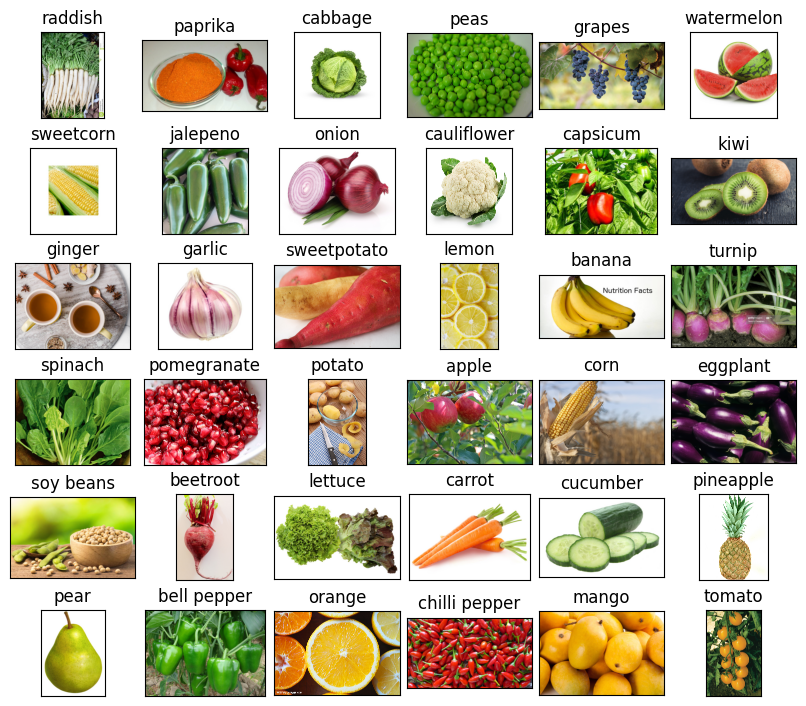

In [28]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display sample images
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

In [29]:
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)


In [30]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(  # Use the same generator for validation data
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False  # Don't shuffle test data
)

Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.


In [31]:
# Build the model from scratch
inputs = tf.keras.layers.Input(shape=(224, 224, 3))  # Input layer

# Example convolutional architecture (can be customized)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)  # Flatten the output from convolutional layers

# Fully connected layers
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Output layer with softmax activation for your number of classes
outputs = tf.keras.layers.Dense(36, activation='softmax')(x)  # Adjust the number of classes (36 in this example)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [32]:
# Compile the model for image classification
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
# Train the model with early stopping for validation loss
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=32,
    epochs=10,  # Adjust the number of epochs based on your dataset
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
90/90 [==============================] - 175s 2s/step - loss: 3.2229 - accuracy: 0.1086 - val_loss: 2.2986 - val_accuracy: 0.3235
Epoch 2/10
90/90 [==============================] - 151s 2s/step - loss: 2.3127 - accuracy: 0.3201 - val_loss: 1.5974 - val_accuracy: 0.5618
Epoch 3/10
90/90 [==============================] - 144s 2s/step - loss: 1.8097 - accuracy: 0.4644 - val_loss: 1.0502 - val_accuracy: 0.6912
Epoch 4/10
90/90 [==============================] - 142s 2s/step - loss: 1.2452 - accuracy: 0.6270 - val_loss: 0.6038 - val_accuracy: 0.8441
Epoch 5/10
90/90 [==============================] - 142s 2s/step - loss: 0.7062 - accuracy: 0.7891 - val_loss: 0.4457 - val_accuracy: 0.8912
Epoch 6/10
90/90 [==============================] - 142s 2s/step - loss: 0.3130 - accuracy: 0.9096 - val_loss: 0.2525 - val_accuracy: 0.9529
Epoch 7/10
90/90 [==============================] - 142s 2s/step - loss: 0.1495 - accuracy: 0.9646 - val_loss: 0.2854 - val_accuracy: 0.9559
Epoch 8/10
90

In [34]:
# Predict labels for test images
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)  # Get the class index with the highest probability

# Map numeric predictions to class labels (assuming labels match folder names)
pred1 = [train_df['Label'].iloc[i] for i in pred]  # Use actual labels from train_df


11/11 [==============================] - 12s 1s/step


In [35]:
def predict_image(image_path):
    """
    Predicts the label of a given image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        str: Predicted class label.
    """

    img = load_img(image_path, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    y_class = prediction.argmax(axis=-1)
    y = int(y_class)
    return train_df['Label'].iloc[y]  # Use actual labels from train_df


In [38]:
img_path = r"C:\Users\ganes\Desktop\try2\dataset\test\cabbage\Image_1.jpg"
predicted_label = predict_image(img_path)
print(f"Predicted label for {img_path}: {predicted_label}")


1/1 [==============================] - 0s 157ms/step
Predicted label for C:\Users\ganes\Desktop\try2\dataset\test\cabbage\Image_1.jpg: onion


In [39]:
model.save('FV.h5')  # Use a different filename to avoid conflicts
